In [2]:
# %pip install tensorflow-probability==0.18.0

In [3]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [184]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
from mixture_models import GMCM, GMC
import utils_v1 as utl
import seaborn as sns

# turning on the latex in pyplot
plt.rcParams['text.usetex'] = False

In [5]:
np.random.seed(10)
n_dims,n_comps=3,2
num_params=int(n_comps*(1+n_dims+n_dims*(n_dims+1)/2))
param_vec=np.random.randn(num_params).astype('float32')
gmm_params=utl.vec2gmm_params(n_dims,n_comps,param_vec)
alphas=tf.math.softmax(gmm_params[0])
mus=gmm_params[1]
covs=gmm_params[2]

alphas,mus,covs,_=utl.standardize_gmm_params(alphas,mus,covs)

gmm_obj = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.MultivariateNormalFullCovariance(loc=mus,
                                                                 covariance_matrix=covs))  # And same here.
tf.random.set_seed(1)
samps=gmm_obj.sample(1000)

marg1=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,0],
                                       scale=covs[:,0,0]**0.5))  # And same here.

marg2=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,1],
                                       scale=covs[:,1,1]**0.5))  # And same here.

marg3=tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=alphas),
    components_distribution=tfd.Normal(loc=mus[:,2],
                                       scale=covs[:,2,2]**0.5))  # And same here.

2023-01-15 12:22:12.298015: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-15 12:22:12.298121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-181-140.ec2.internal): /proc/driver/nvidia/version does not exist
2023-01-15 12:22:12.300033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [6]:
u1=marg1.cdf(samps[:,0]).numpy().reshape(-1,1)
u2=marg2.cdf(samps[:,1]).numpy().reshape(-1,1)
u3=marg3.cdf(samps[:,2]).numpy().reshape(-1,1)
u_mat=np.concatenate([u1,u2,u3],axis=1)

In [108]:
gmc_obj=GMC(n_dims,n_comps)
gmc_obj.init_params(['random',0])
ll_reg,_,params_updates_reg=gmc_obj.fit_dist(u_mat,
                 n_comps, 
                 optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
                 max_iters =2000, 
                 batch_size = 1000, 
                 print_interval=500, 
                 regularize=True, 
                 plot_results = False,
                 return_param_updates=True)


@ Iter:0,                         Training error: 0.4,                         Validation error: nan,                         Time Elapsed: 4.3 s
@ Iter:500,                         Training error: -0.4,                         Validation error: nan,                         Time Elapsed: 29.5 s
@ Iter:1000,                         Training error: -0.8,                         Validation error: nan,                         Time Elapsed: 52.6 s
@ Iter:1500,                         Training error: -0.8,                         Validation error: nan,                         Time Elapsed: 76.8 s


In [109]:
# Now training the GMC distribution without regularization
gmc_obj=GMC(n_dims,n_comps)
gmc_obj.init_params(['random',0])
ll_nonreg,_,params_updates_nonreg=gmc_obj.fit_dist(
    u_mat,
    n_comps, 
    optimizer = tf.optimizers.Adam(learning_rate=1E-3), 
    max_iters =2000, 
    batch_size = 1000, 
    print_interval=500, 
    regularize=False, 
    plot_results = False,
    return_param_updates=True)


@ Iter:0,                         Training error: 0.4,                         Validation error: nan,                         Time Elapsed: 3.8 s
@ Iter:500,                         Training error: -0.3,                         Validation error: nan,                         Time Elapsed: 28.5 s
@ Iter:1000,                         Training error: -0.8,                         Validation error: nan,                         Time Elapsed: 50.7 s
@ Iter:1500,                         Training error: -0.8,                         Validation error: nan,                         Time Elapsed: 72.8 s


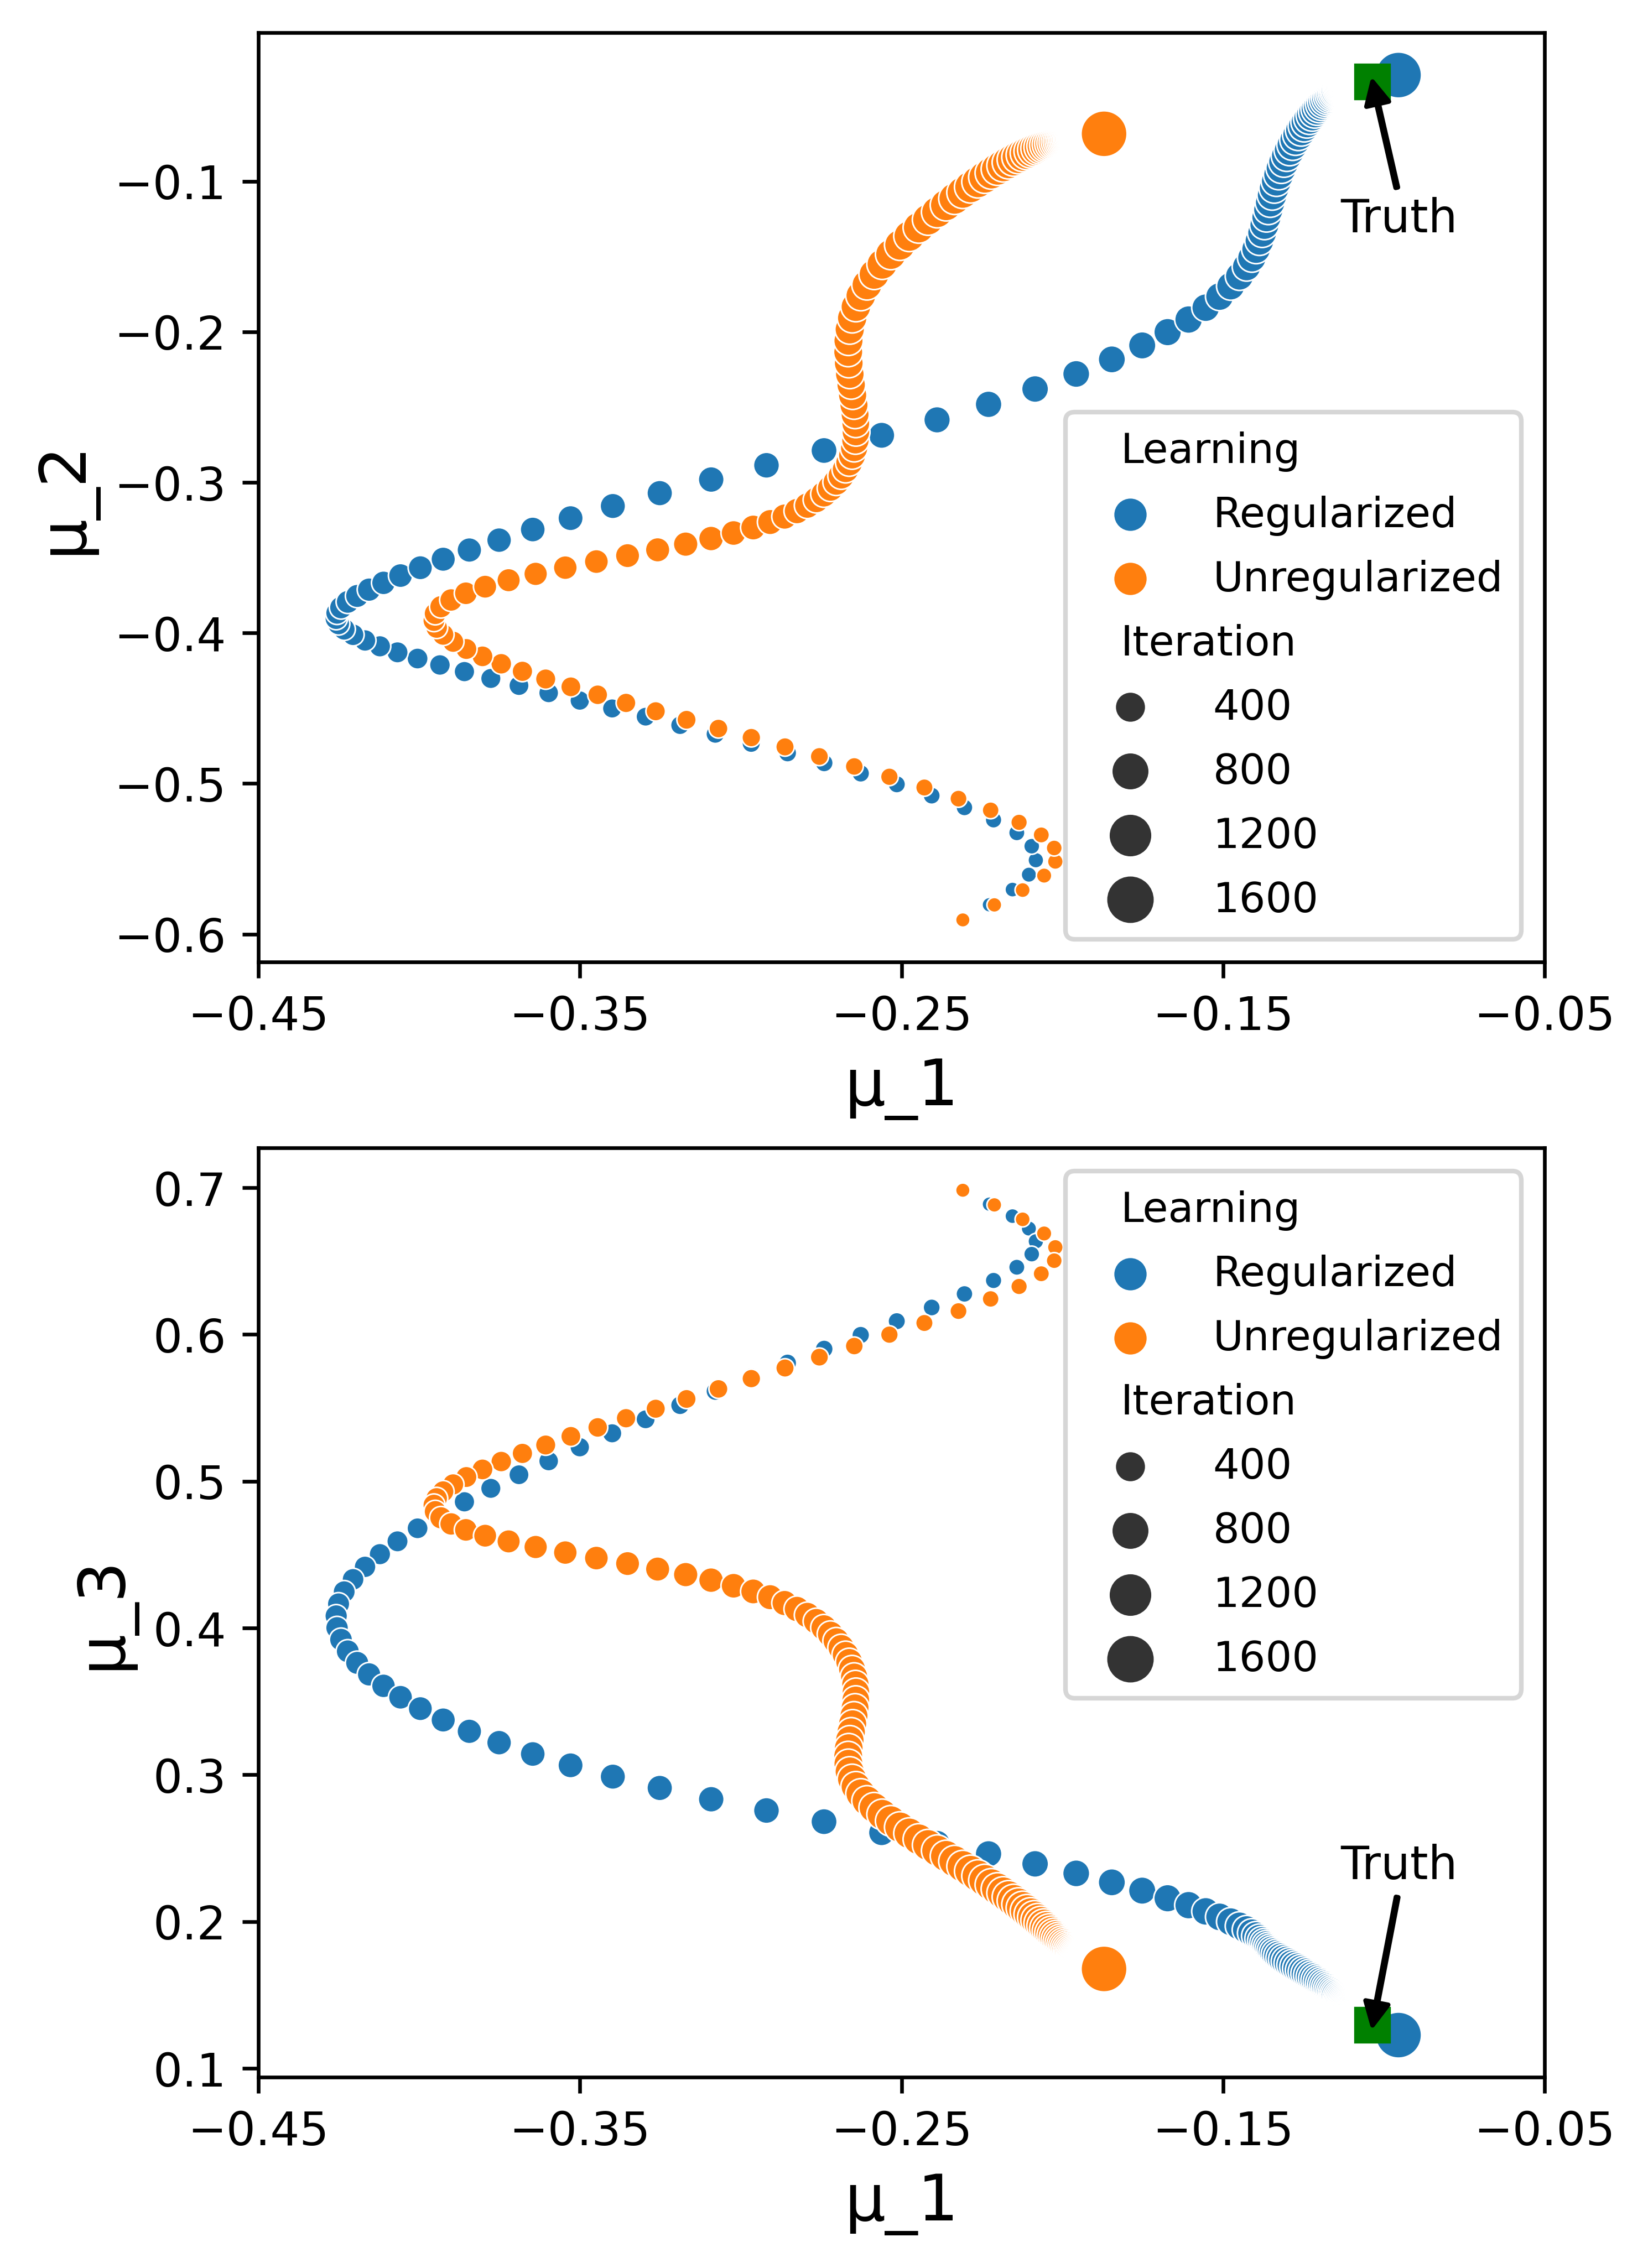

In [200]:
id1,id2,id3=2,3,4
df_reg=pd.DataFrame({'mu_1':params_updates_reg[:,id1],
                     'mu_2':params_updates_reg[:,id2],
                     'mu_3':params_updates_reg[:,id3],
                     'Iteration':np.arange(1,2001)})
df_reg['Learning']='Regularized'

df_nonreg=pd.DataFrame({'mu_1':params_updates_nonreg[:,id1],
                        'mu_2':params_updates_nonreg[:,id2],
                        'mu_3':params_updates_nonreg[:,id3],
                        'Iteration':np.arange(1,2001)})
df_nonreg['Learning']='Unregularized'

df_reg=df_reg.iloc[np.arange(0,2000,10).tolist()]
df_nonreg=df_nonreg.iloc[np.arange(0,2000,10).tolist()]

df=pd.concat((df_reg,df_nonreg),axis=0)

fig,ax=plt.subplots(2,1,figsize=(5,8),dpi=600)
sns.scatterplot(data=df, 
                x="mu_1", 
                y="mu_2",
                hue="Learning",
                size="Iteration",
                sizes=(10, 100),
                ax=ax[0])
ax[0].plot(mus[0,0],mus[0,1],'gs',markersize=7)
ax[0].annotate('Truth', xy=(mus[0,0],mus[0,1]), xytext=(mus[0,0]-0.01,mus[0,1]-0.1),
            arrowprops=dict(facecolor='black',width=0.5,headwidth=5,headlength=5))
ax[0].set_xlim([-0.45,-0.05]);
plt.setp(ax[0].get_legend().get_texts(), fontsize='9') 
ax[0].set_xticks([-0.45, -0.35,-0.25,-0.15,-0.05]) #unicode symbol for mu
ax[0].set_xlabel('\u03BC_1',fontsize=14) #unicode symbol for mu
ax[0].set_ylabel('\u03BC_2',fontsize=14) #unicode symbol for mu

sns.scatterplot(data=df, 
                x="mu_1", 
                y="mu_3",
                hue="Learning",
                size="Iteration",
                sizes=(10, 100),
                ax=ax[1])
ax[1].plot(mus[0,0],mus[0,2],'gs',markersize=7)
ax[1].annotate('Truth', xy=(mus[0,0],mus[0,2]), xytext=(mus[0,0]-0.01,mus[0,2]+0.1),
            arrowprops=dict(facecolor='black',width=0.5,headwidth=5,headlength=5))
ax[1].set_xlim([-0.45,-0.05]);
ax[1].set_xticks([-0.45, -0.35,-0.25,-0.15,-0.05]) 
plt.setp(ax[1].get_legend().get_texts(), fontsize='9') ;
ax[1].set_xlabel('\u03BC_1',fontsize=14) #unicode symbol for mu
ax[1].set_ylabel('\u03BC_3',fontsize=14) #unicode symbol for mu

# saving figure
plt.savefig('Identifiability_Experiment.png', bbox_inches='tight')
